## Multivariate Anomaly Detection of sequential data using an LSTM Autoencoder
### Architecture defined in [Malhotra2016](https://arxiv.org/pdf/1607.00148.pdf) and Pytorch implementation found in [this blog post](https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)

## Generate Synthetic Data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def syntheticdata(timesteps=100, loc=0, scale=.1, hz=3, seed=None):
    np.random.seed(seed)
    t = np.linspace(0, hz, timesteps)
    sine_wave = np.sin(2*np.pi*t)
    
    noise = np.random.normal(loc=loc, scale=scale, size=timesteps)
    sine_wave = sine_wave + noise
    
    return sine_wave


def generate_cycle(cycle_id, starting_seed=0):
    cycle_data = []
    for i in range(starting_seed, starting_seed+10):
        cycle_data.append(syntheticdata(seed=i))
    cycle_data_df = pd.DataFrame(cycle_data).T
    cycle_data_df['cycle_id'] = cycle_id
    return cycle_data_df

In [3]:
df  = pd.DataFrame(columns =  ['cycle_id'] + [i for i in range(10)])

for cycle_id in range(20):
    cycle_data_df = generate_cycle(cycle_id=str(cycle_id), starting_seed=cycle_id*10)
    df = pd.concat([df, cycle_data_df], axis=0)

df

,cycle_id,0,1,2,3,4,5,6,7,8,9
0,0,0.176405,0.162435,-0.041676,0.178863,0.005056,0.044123,-0.031178,0.169053,0.009120,0.000111
1,0,0.229267,0.128076,0.183625,0.232902,0.239246,0.156164,0.262152,0.142658,0.298380,0.160297
2,0,0.469536,0.318845,0.158043,0.381312,0.272072,0.614740,0.393445,0.374944,0.176965,0.260056
3,0,0.764730,0.433344,0.704668,0.354292,0.610001,0.515432,0.450732,0.581392,0.402006,0.539353
4,0,0.876835,0.776620,0.510735,0.662340,0.648249,0.701040,0.441401,0.611187,0.460430,0.652243
...,...,...,...,...,...,...,...,...,...,...,...
95,19,-0.532534,-0.686623,-0.762353,-0.602476,-0.749612,-0.701857,-0.623503,-0.733076,-0.769273,-0.623686
96,19,-0.443588,-0.505072,-0.696151,-0.460968,-0.494662,-0.622627,-0.437160,-0.497123,-0.509194,-0.377810
97,19,-0.421385,-0.417605,-0.214248,-0.294934,-0.273429,-0.440549,-0.395213,-0.378549,-0.347215,-0.360793
98,19,-0.152791,-0.333159,-0.135231,-0.235356,-0.131583,-0.163301,-0.283380,-0.365197,-0.235974,-0.115862


<AxesSubplot:>

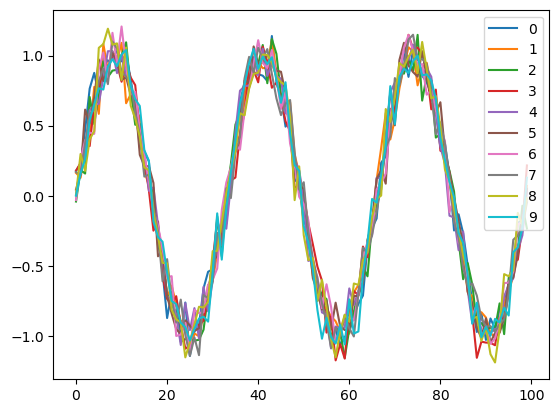

In [4]:
df[df['cycle_id']=='0'].plot()

<AxesSubplot:>

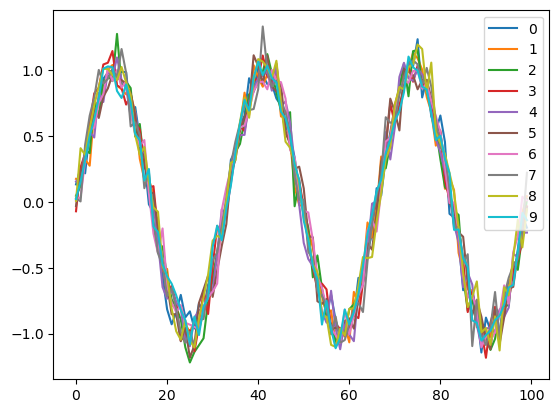

In [5]:
df[df['cycle_id']=='1'].plot()

## Prepare Pytorch Tensors

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def create_dataloader(df, batch_size: int=1, shuffle: bool=False, drop_last=False):
    
    for i, (cycle, cycle_grp) in enumerate(df.groupby('cycle_id')):
        cycle_tmp = cycle_grp.drop(columns=['cycle_id'])
        cycle_tmp = np.expand_dims(cycle_tmp, axis=0)
        if i == 0: dataset = cycle_tmp
        else: dataset = np.vstack((dataset, cycle_tmp))
    n_seq, seq_len, n_features = dataset.shape
    dataset = torch.FloatTensor(dataset)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    return dataloader, seq_len, n_features

def create_dataset(df):
    df = df.drop(columns=['cycle_id'])
    df = np.expand_dims(df, axis=0)
    dataset = torch.FloatTensor(df)
    return dataset


In [7]:
df_train = df[df['cycle_id'].isin(['0', '1', '2', '3', '4', '5', '6'])]
df_val = df[df['cycle_id'].isin(['7', '8', '9'])]


train_dataloader, seq_len, n_features = create_dataloader(df_train, batch_size=2, shuffle=True, drop_last=True)
val_dataloader, _, _ = create_dataloader(df_val)

In [8]:
train_i = next(iter(train_dataloader))
train_i.shape

torch.Size([2, 100, 10])

## Define Model Architecture

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_dim, out_dim, h_dims, h_activ, out_activ):
        super(Encoder, self).__init__()

        layer_dims = [input_dim] + h_dims + [out_dim]
        self.num_layers = len(layer_dims) - 1
        self.layers = nn.ModuleList()
        self.out_dim = out_dim
        
        for index in range(self.num_layers):
            layer = nn.LSTM(
                input_size=layer_dims[index],
                hidden_size=layer_dims[index + 1],
                num_layers=1,
                batch_first=True
            )
            self.layers.append(layer)

        self.h_activ, self.out_activ = h_activ, out_activ

    def forward(self, x):

        for index, layer in enumerate(self.layers):
            x, (h_n, c_n) = layer(x)

            if self.h_activ and index < self.num_layers - 1:
                x = self.h_activ(x)
            elif self.out_activ and index == self.num_layers - 1:
                return self.out_activ(h_n).reshape(-1, self.out_dim)

        return h_n.reshape(-1, self.out_dim)


class Decoder(nn.Module):
    def __init__(self, input_dim, out_dim, h_dims, h_activ):
        super(Decoder, self).__init__()

        layer_dims = [input_dim] + h_dims + [out_dim]
        self.num_layers = len(layer_dims) - 1
        self.layers = nn.ModuleList()
        
        for index in range(self.num_layers):
            layer = nn.LSTM(
                input_size=layer_dims[index],
                hidden_size=layer_dims[index + 1],
                num_layers=1,
                batch_first=True
            )
            self.layers.append(layer)

        self.h_activ = h_activ
        self.dense_matrix = nn.Parameter(
            torch.rand((out_dim, out_dim), dtype=torch.float),
            requires_grad=True
        )

    def forward(self, x, seq_len):
        x = x.unsqueeze(1).repeat(1, seq_len, 1) # now make [batch_size, num_features] -> [batch_size, seq_len, num_features]
        for index, layer in enumerate(self.layers):
            x, (h_n, c_n) = layer(x)

            if self.h_activ and index < self.num_layers - 1:
                x = self.h_activ(x)

        return torch.matmul(x, self.dense_matrix)


######
# MAIN
######

class LSTM_AE(nn.Module):
    def __init__(self, input_dim, encoding_dim, h_dims=[], h_activ=nn.Sigmoid(),
                 out_activ=nn.Tanh()):
        super(LSTM_AE, self).__init__()

        self.encoder = Encoder(input_dim, encoding_dim, h_dims, h_activ, out_activ)
        self.decoder = Decoder(encoding_dim, input_dim, h_dims[::-1], h_activ)

    def forward(self, x):
        seq_len = x.shape[1] # [batch, seq_len, features]
        x = self.encoder(x)
        x = self.decoder(x, seq_len)

        return x

## Define Training

In [10]:
from torch.nn import MSELoss


def train_model(
    model,
    device,
    train_dataloader,
    val_dataloader,
    lr, 
#     lr_decay,
#     lr_gamma,
    epochs, 
    denoise=False,
    verbose=True,
):
    # TODO: move device to notebook
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # initialise optimiser
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)
#     if lr_decay: lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser=optimiser, gamma=lr_gamma, last_epoch=-1)

    # initialise loss
    criterion = MSELoss(reduction='mean')

    history = dict(train=[], val=[])

    for epoch in range(1, epochs + 1):
        
        model.train()

        train_losses = []

        for i, x in enumerate(train_dataloader):

            optimiser.zero_grad()

            # Forward pass
            x_prime = model(x)

            loss = criterion(x_prime, x)

            # Backward pass
            loss.backward()
            optimiser.step()

            train_losses.append(loss.item())
        
        train_loss = np.mean(train_losses)

            
            
        val_losses = []
        model = model.eval()

        # estimate validation loss
        with torch.no_grad():
            for i, seq_true in enumerate(val_dataloader):
                seq_pred = model(seq_true)
                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())
                
        val_loss = np.mean(val_losses)

        # now store the losses for this epoch
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        

        # output the losses if verbose
        if verbose:
            print(f"Epoch: {epoch}, Training Loss: {train_loss}, Validation Loss: {val_loss}")
    
    # output the final losses per cycle for the val dataset
    history['val_cycle_loss'] = val_losses
    
    return history


def get_encodings(model, dataset):
    model.eval()
    encodings = [model.encoder(x) for x in train_set]
    return encodings


######
# MAIN
######


def train(
    model, 
    device,
    train_dataloader,
    val_dataloader,
#     encoding_dim,  
    lr=1e-3,
    epochs=50, 
    denoise=False, 
    verbose=False,
    **kwargs
):
#     model = instantiate_model(model, train_set, encoding_dim, **kwargs)
    losses = train_model(model, device, train_dataloader, val_dataloader, lr, epochs, denoise, verbose)
#     encodings = get_encodings(model, train_set)

    return model, losses

In [11]:
# parameter options
learning_rate = 1e-3
input_features = n_features
encoding_size = 8
h_dims_sizes = [16] # list of decreasing integers, with each entry being a layer width

In [12]:
model = LSTM_AE(input_dim=10, encoding_dim=8, h_dims=[16])
model

LSTM_AE(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): LSTM(10, 16, batch_first=True)
      (1): LSTM(16, 8, batch_first=True)
    )
    (h_activ): Sigmoid()
    (out_activ): Tanh()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): LSTM(8, 16, batch_first=True)
      (1): LSTM(16, 10, batch_first=True)
    )
    (h_activ): Sigmoid()
  )
)

In [13]:
model, history = train(
    model, 
    device,
    train_dataloader,
    val_dataloader,
    lr=1e-3,
    epochs=100,
    verbose=True,
)

Epoch: 1, Training Loss: 0.5361113349596659, Validation Loss: 0.5238354802131653
Epoch: 2, Training Loss: 0.5263086358706156, Validation Loss: 0.5213297605514526
Epoch: 3, Training Loss: 0.5236827731132507, Validation Loss: 0.5170857707659403
Epoch: 4, Training Loss: 0.5171208182970682, Validation Loss: 0.5120954513549805
Epoch: 5, Training Loss: 0.5140970150629679, Validation Loss: 0.5093702872594198
Epoch: 6, Training Loss: 0.5115463534990946, Validation Loss: 0.5077532927195231
Epoch: 7, Training Loss: 0.5088717937469482, Validation Loss: 0.5058619777361552
Epoch: 8, Training Loss: 0.507736066977183, Validation Loss: 0.5044722159703573
Epoch: 9, Training Loss: 0.5056449770927429, Validation Loss: 0.5038978755474091
Epoch: 10, Training Loss: 0.5050827264785767, Validation Loss: 0.5032401978969574
Epoch: 11, Training Loss: 0.5052286982536316, Validation Loss: 0.5024802386760712
Epoch: 12, Training Loss: 0.5048047304153442, Validation Loss: 0.5018159846464793
Epoch: 13, Training Loss: 

Epoch: 99, Training Loss: 0.014773306747277578, Validation Loss: 0.01352526806294918
Epoch: 100, Training Loss: 0.014001667189101378, Validation Loss: 0.013442715940376123


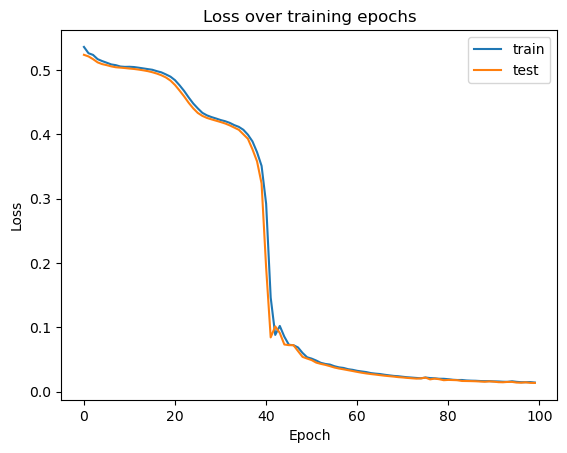

In [14]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

/var/folders/db/zt3c7s151gg33mj9zf3czwnr0000gn/T/ipykernel_5191/2174955979.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df_plot[9] = val_df_plot[9] *0.5
/var/folders/db/zt3c7s151gg33mj9zf3czwnr0000gn/T/ipykernel_5191/2174955979.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


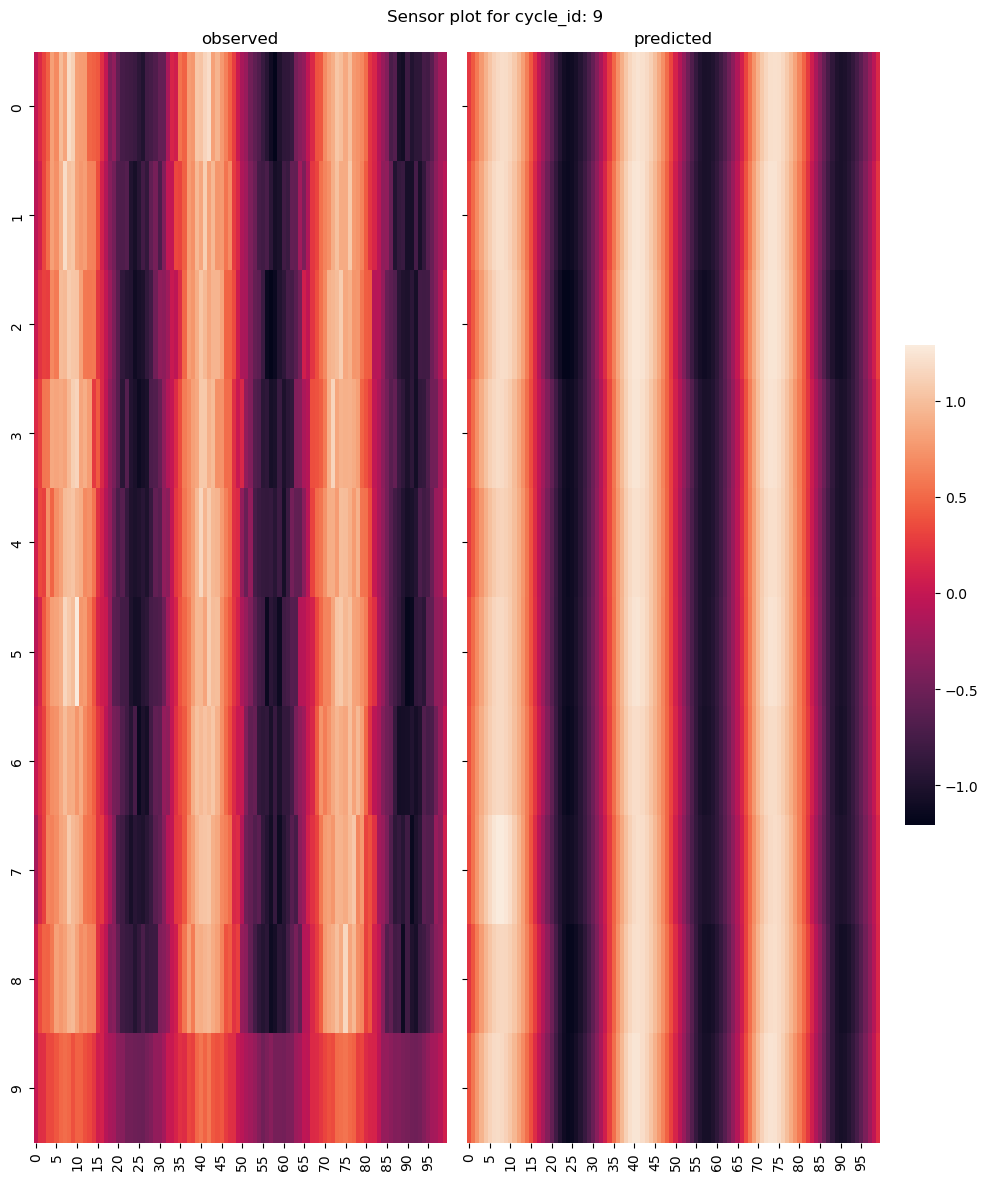

In [32]:
import seaborn as sns

test_cycle_id = '9'
val_df_plot = df_val.loc[df_val.cycle_id==test_cycle_id]
val_df_plot[9] = val_df_plot[9] *0.5

val_tensor_plot = create_dataset(val_df_plot)

val_df_plot
datasets = {
    'observed': pd.DataFrame(val_tensor_plot.detach().numpy().reshape(-1, n_features).transpose()),
    'predicted': pd.DataFrame(model(val_tensor_plot).detach().numpy().reshape(-1, n_features).transpose())
}

fig, axes = plt.subplots(figsize=(10,12), nrows=1, ncols=2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

axes = axes.flatten()
for ax, x, title, i in zip(axes, datasets.values(), datasets.keys(), range(len(datasets))):
    ax.set_title(title)
    sns.heatmap(x, ax=ax, cbar=i==0, cbar_ax=None if i else cbar_ax)#, yticklabels=s)
plt.suptitle(f'Sensor plot for cycle_id: {test_cycle_id}')
fig.tight_layout(rect=[0, 0, .9, 1])

In [18]:
model(val_tensor_plot)

tensor([[[ 1.1303e-01,  1.7922e-01,  1.1620e-01,  1.7181e-01,  1.2317e-01,
           1.9435e-01,  2.1485e-01,  2.0442e-01,  8.7246e-02,  2.2479e-01],
         [ 2.5740e-01,  3.3600e-01,  2.6454e-01,  3.4775e-01,  2.6479e-01,
           3.4344e-01,  3.7961e-01,  3.8301e-01,  2.4537e-01,  3.9721e-01],
         [ 4.1740e-01,  4.9307e-01,  4.2682e-01,  5.2131e-01,  4.1867e-01,
           4.9013e-01,  5.3335e-01,  5.5131e-01,  4.2435e-01,  5.5975e-01],
         [ 5.7003e-01,  6.3982e-01,  5.7833e-01,  6.7203e-01,  5.6371e-01,
           6.2981e-01,  6.6956e-01,  7.0261e-01,  5.8604e-01,  7.0362e-01],
         [ 6.9975e-01,  7.6250e-01,  7.0516e-01,  7.8709e-01,  6.8409e-01,
           7.4752e-01,  7.7688e-01,  8.2789e-01,  7.1268e-01,  8.1391e-01],
         [ 8.0148e-01,  8.5511e-01,  8.0441e-01,  8.6595e-01,  7.7480e-01,
           8.3505e-01,  8.5274e-01,  9.2313e-01,  8.0358e-01,  8.8661e-01],
         [ 8.7559e-01,  9.1756e-01,  8.7743e-01,  9.1348e-01,  8.3721e-01,
           8.9176e-

,cycle_id,0,1,2,3,4,5,6,7,8,9
0,9,-0.022449,-0.060612,0.023030,0.163020,0.074345,-0.066429,0.006985,-0.175119,0.047372,-0.014236
1,9,0.166499,0.083257,0.220046,0.299325,0.341370,0.131008,0.184385,0.146291,0.353012,0.394973
2,9,0.312523,0.316570,0.298030,0.577885,0.300977,0.405620,0.305688,0.297024,0.471517,0.399989
3,9,0.460718,0.513072,0.278341,0.587042,0.715919,0.600570,0.576378,0.641326,0.469900,0.673622
4,9,0.809090,0.812304,0.670184,0.855285,0.471737,0.798933,0.703283,0.630967,0.585858,0.674617
...,...,...,...,...,...,...,...,...,...,...,...
95,9,-0.770166,-0.642037,-0.774842,-0.693943,-0.738735,-0.601372,-0.741827,-0.655064,-0.687779,-0.596683
96,9,-0.626802,-0.540767,-0.502774,-0.477672,-0.529090,-0.577033,-0.711899,-0.651531,-0.530137,-0.385377
97,9,-0.387218,-0.337564,-0.354875,-0.469795,-0.260578,-0.300015,-0.487984,-0.267621,-0.351713,-0.362300
98,9,-0.207395,-0.187362,-0.127065,-0.208987,-0.219394,-0.273452,-0.277538,-0.332964,-0.303181,-0.159769
